# Provenance integration with 3rd party libraries

Provena facilitates the capture of provenance primarily using a specialisation of [Prov-O](https://www.w3.org/TR/prov-o/). We are able to interface with Provena provenance information using graph based tools. This guide provides some ideas for fetching provenance information from the Provena Registry and using [prov](https://prov.readthedocs.io/en/latest/) and [rdflib](https://rdflib.readthedocs.io/en/stable/index.html) python libraries. 

This guide will show how you can use `prov` and `rdflib` to serialise into PROV documents and RDF formats. This is useful if you would like to use those toolsets to query, integrate with other PROV/RDF data, or visualise using tools such as GraphViz.

Pre-requisites will be:
* rdflib
* prov
* graphviz

## Using Prov and rdflib python libraries

First initialise the provena client.

In [1]:
from provenaclient import ProvenaClient, Config
from provenaclient.auth import DeviceFlow
from provenaclient.auth.implementations import OfflineFlow
from ProvenaInterfaces.RegistryAPI import *
from ProvenaInterfaces.RegistryModels import *
client_config = Config(
        domain="dev.rrap-is.com",
        realm_name="rrap"
    )
auth = DeviceFlow(config=client_config, client_id="client-tools")

client = ProvenaClient(auth=auth, config=client_config)

Query all model run records. Prov compatible data is currently available from Provena primarily from model run records as it specialises from `prov:Activity` and relates relevant `Entities` and `Agents` via that construct. 

In [2]:
# Get model run record in the Provena registry
model_run_record_list = await client.registry.model_run.list_items(GeneralListRequest(
    filter_by=None,
    sort_by=None,
    pagination_key=None
))

model_run_record = model_run_record_list.items.pop()

We can instantiate the `PROV` compatible serialisation of the model run into a `ProvDocument` using the `Prov` python library. This will allow us to interact natively with the provenance document in Python.

In [3]:
import prov.model as pm

# Get a Prov document from the record
document = pm.ProvDocument.deserialize(source=None, content=model_run_record.prov_serialisation)


The prov representation of the model run record is quite minimal. The available attributes are: `id`, `item_category`, `item_subtype`. However, from this information alone, we can enrich the prov document/graph with additional info by fetching it from the Registry. 

We show the use of `general_fetch_item()`, which returns general info such as the label. However, you can use the more specialised `fetch()` in the provena client that allows more specific info to be fetched from the item, e.g. `Model` details or `Dataset` metadata.

In [ ]:
# Resolve labels by fetching items from the registry
for r in document.get_records():   
    if r.get_attribute('id'): #only fetch labels if the record has an ID attribute
        id = next(iter(r.get_attribute('id')))
        item_category = next(iter(r.get_attribute('item_category')))
        item_subtype = next(iter(r.get_attribute('item_subtype')))
        print(f"{id} {r.get_type()} {item_category} {item_subtype}")
        res = await client.registry.general_fetch_item(id=id)
        print(f"{res.item['display_name']} {res.item['item_subtype']}")
        
        #Add the label to the prov doc for this record
        r.add_attributes( {'prov:label': res.item['display_name']} )

10378.1/1964491 prov:Activity ACTIVITY MODEL_RUN
study example MODEL_RUN
10378.1/1964490 prov:Activity ACTIVITY STUDY
study 2 STUDY
10378.1/1963761 prov:Entity ENTITY WORKFLOW_TEMPLATE
test MODEL_RUN_WORKFLOW_TEMPLATE
10378.1/1963759 prov:Entity ENTITY MODEL
test MODEL
10378.1/1963764 prov:Entity ENTITY DATASET
output DATASET
10378.1/1963760 prov:Entity ENTITY DATASET_TEMPLATE
input DATASET_TEMPLATE
10378.1/1963721 prov:Entity ENTITY DATASET
FIRST dataset DATASET
10378.1/1963718 prov:Agent AGENT PERSON
Peter 0.1x-dev Baker PERSON
10378.1/1963720 prov:Agent AGENT ORGANISATION
CSIRO ORGANISATION


In [5]:
# Serialise this to RDF/Turtle using underlying rdflib 
print(document.serialize(format='rdf', rdf_format='ttl'))

@prefix ns1: <http://hdl.handle.net/> .
@prefix prov: <http://www.w3.org/ns/prov#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://hdl.handle.net/10378.1/1963764> a prov:Entity ;
    rdfs:label "output"^^xsd:string ;
    ns1:id "10378.1/1963764"^^xsd:string ;
    ns1:item_category "ENTITY"^^xsd:string ;
    ns1:item_subtype "DATASET"^^xsd:string ;
    prov:wasAttributedTo <http://hdl.handle.net/10378.1/1963718> ;
    prov:wasGeneratedBy <http://hdl.handle.net/10378.1/1964491> ;
    prov:wasInfluencedBy <http://hdl.handle.net/10378.1/1963760> .

<http://hdl.handle.net/10378.1/1963720> a prov:Agent ;
    rdfs:label "CSIRO"^^xsd:string ;
    ns1:id "10378.1/1963720"^^xsd:string ;
    ns1:item_category "AGENT"^^xsd:string ;
    ns1:item_subtype "ORGANISATION"^^xsd:string .

<http://hdl.handle.net/10378.1/1963721> a prov:Entity ;
    rdfs:label "FIRST dataset"^^xsd:string ;
    ns1:id "10378.1/1963721"^^xsd:string ;
    n

In [6]:
# other prov syntax
print(document.get_provn())

document
  default <http://hdl.handle.net/>
  
  activity(10378.1/1964491, -, -, [id="10378.1/1964491", item_category="ACTIVITY", item_subtype="MODEL_RUN", prov:label="study example"])
  activity(10378.1/1964490, -, -, [id="10378.1/1964490", item_category="ACTIVITY", item_subtype="STUDY", prov:label="study 2"])
  entity(10378.1/1963761, [id="10378.1/1963761", item_category="ENTITY", item_subtype="WORKFLOW_TEMPLATE", prov:label="test"])
  entity(10378.1/1963759, [id="10378.1/1963759", item_category="ENTITY", item_subtype="MODEL", prov:label="test"])
  entity(10378.1/1963764, [id="10378.1/1963764", item_category="ENTITY", item_subtype="DATASET", prov:label="output"])
  entity(10378.1/1963760, [id="10378.1/1963760", item_category="ENTITY", item_subtype="DATASET_TEMPLATE", prov:label="input"])
  entity(10378.1/1963721, [id="10378.1/1963721", item_category="ENTITY", item_subtype="DATASET", prov:label="FIRST dataset"])
  agent(10378.1/1963718, [id="10378.1/1963718", item_category="AGENT", it

## Visualisation using Graphviz

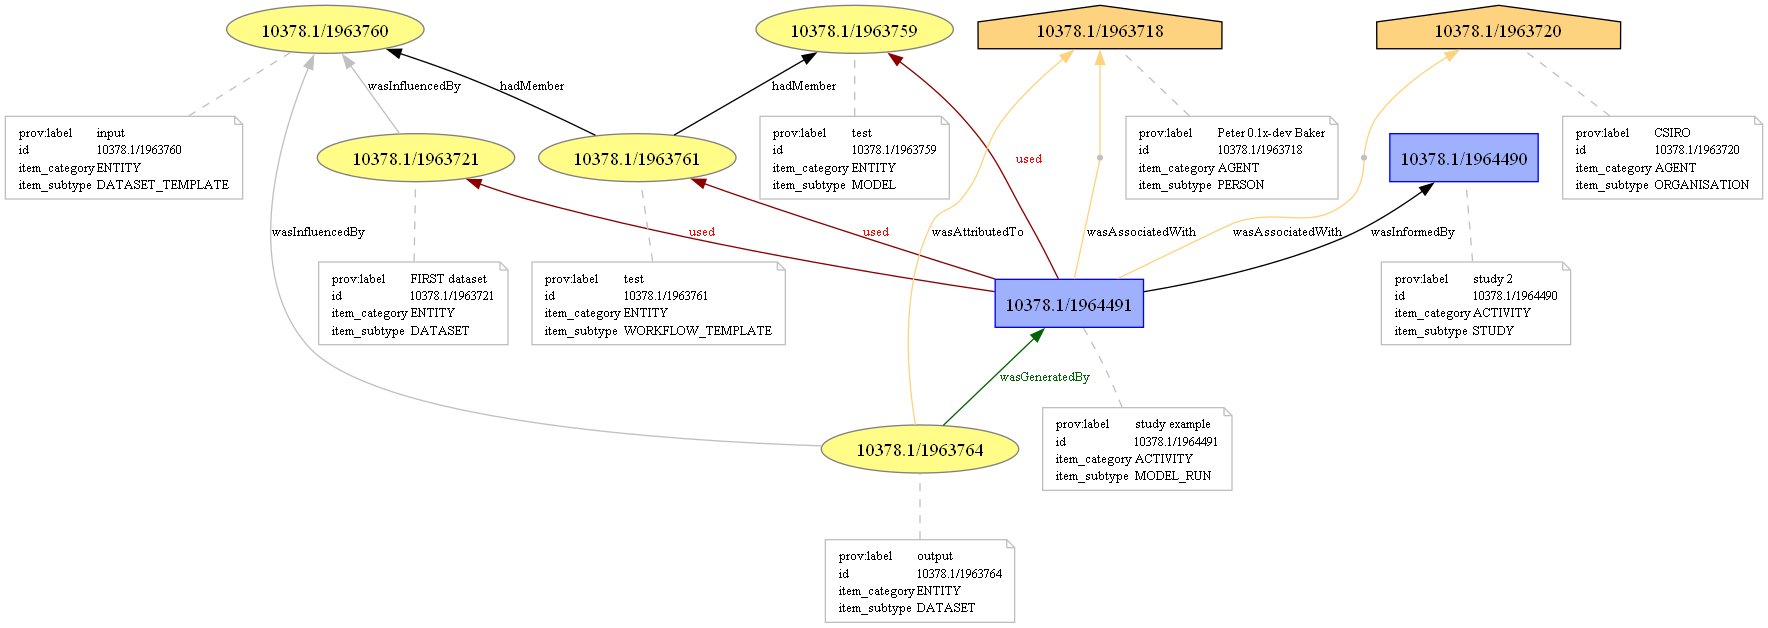

In [7]:
from prov.dot import prov_to_dot
from IPython.display import Image

# render into file
dot = prov_to_dot(document)
name = "prov_graph"

dot.write_png(name + '.png')
Image(name + '.png')

## Advanced use case: Querying and joining graphs

You may want to build out a graph from your starting point. The following shows how we can expand the provenance graph from a starting point.

In [8]:
from provenaclient.models.general import CustomLineageResponse
from prov.model import ProvDocument
#let's use the previous model run graph as a starting point

#fetch upstream nodes from 
upstream_result = await client.prov_api.explore_upstream(model_run_record.id)

for node in upstream_result.graph.nodes:
    if node.item_subtype == ItemSubType.MODEL_RUN:
        print(f"{node}")
        #fetch and add prov doc to existing doc
        mr = await client.registry.model_run.fetch(id=node.id)
        doc = pm.ProvDocument.deserialize(source=None, content=mr.item.prov_serialisation)
        records = doc.get_records()
        for r in records:
            document.add_record(r)
            if r.get_attribute('id'):
                id = next(iter(r.get_attribute('id')))
                res = await client.registry.general_fetch_item(id=id)
                r.add_attributes( {'prov:label': res.item['display_name']} )
            print(r)

        
print(document.get_provn())

id='10378.1/1964491' item_category=<ItemCategory.ACTIVITY: 'ACTIVITY'> item_subtype=<ItemSubType.MODEL_RUN: 'MODEL_RUN'>
activity(10378.1/1964491, -, -, [id="10378.1/1964491", item_category="ACTIVITY", item_subtype="MODEL_RUN", prov:label="study example"])
activity(10378.1/1964490, -, -, [id="10378.1/1964490", item_category="ACTIVITY", item_subtype="STUDY", prov:label="study 2"])
entity(10378.1/1963761, [id="10378.1/1963761", item_category="ENTITY", item_subtype="WORKFLOW_TEMPLATE", prov:label="test"])
entity(10378.1/1963759, [id="10378.1/1963759", item_category="ENTITY", item_subtype="MODEL", prov:label="test"])
entity(10378.1/1963764, [id="10378.1/1963764", item_category="ENTITY", item_subtype="DATASET", prov:label="output"])
entity(10378.1/1963760, [id="10378.1/1963760", item_category="ENTITY", item_subtype="DATASET_TEMPLATE", prov:label="input"])
entity(10378.1/1963721, [id="10378.1/1963721", item_category="ENTITY", item_subtype="DATASET", prov:label="FIRST dataset"])
agent(10378.1

Visualise the prov graph using GraphViz

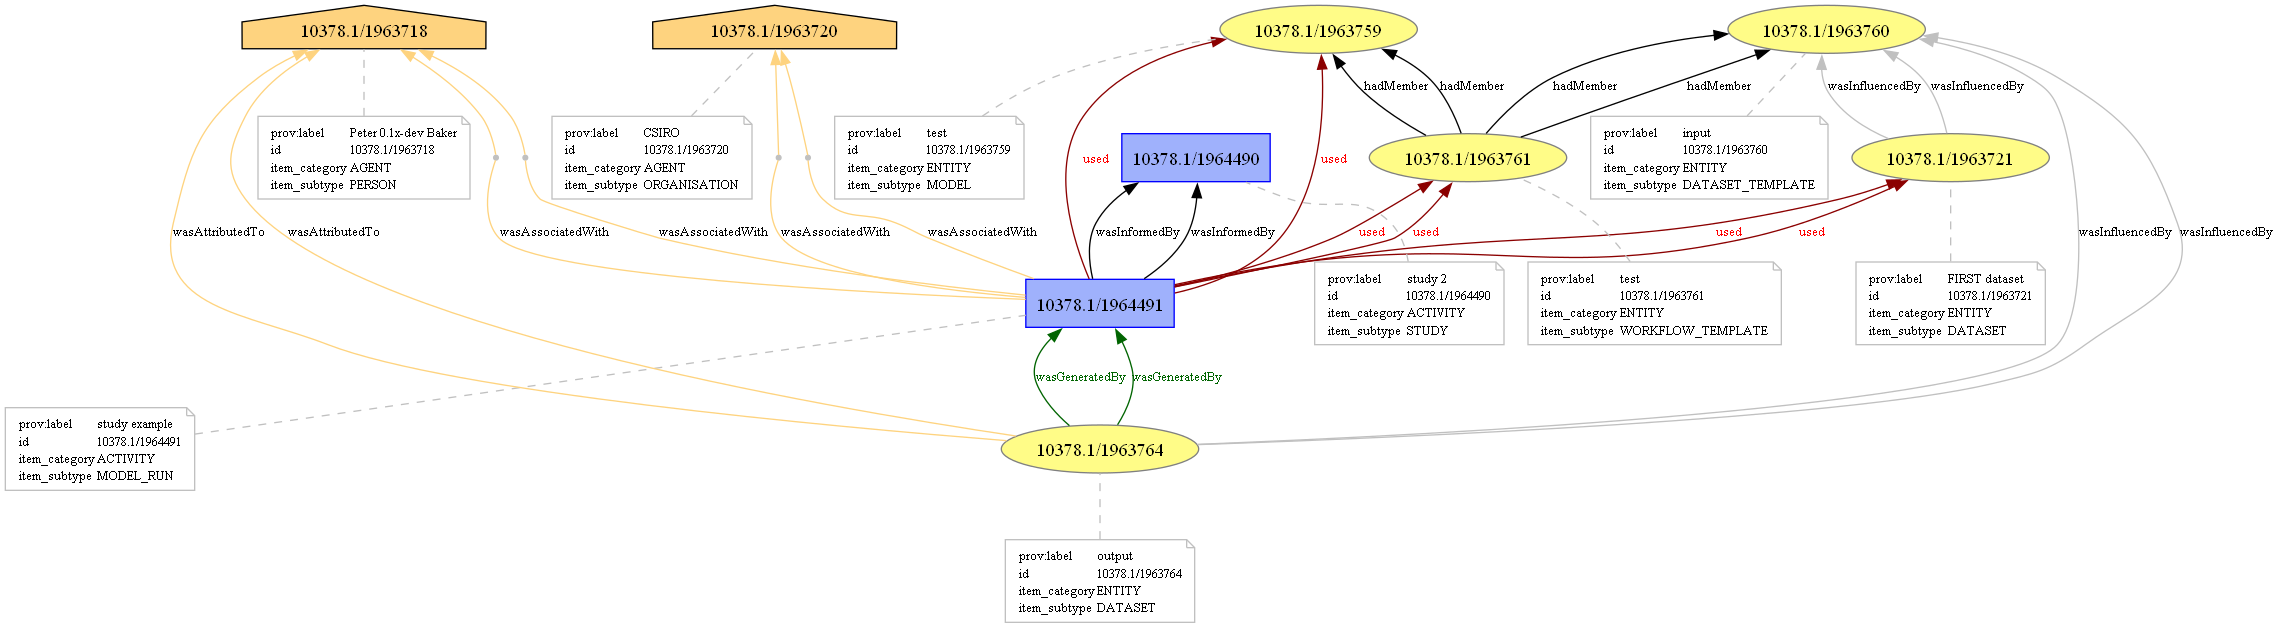

In [9]:
from prov.dot import prov_to_dot
from IPython.display import Image

# render into file
dot = prov_to_dot(document)
name = "prov_graph2"

dot.write_png(name + '.png')
Image(name + '.png')

Let's look at one of the input datasets and get all upstream and downstream things from it

In [ ]:
dataset_id = "10378.1/1963721" #this will be different for your context

#fetch upstream nodes from 
upstream_result = await client.prov_api.explore_upstream(dataset_id)
downstream_result = await client.prov_api.explore_downstream(dataset_id)

for node in upstream_result.graph.nodes:
    if node.item_subtype == ItemSubType.MODEL_RUN:
        print(f"{node}")
        #fetch and add prov doc to existing doc
        mr = await client.registry.model_run.fetch(id=node.id)
        doc = pm.ProvDocument.deserialize(source=None, content=mr.item.prov_serialisation)
        records = doc.get_records()
        for r in records:
            document.add_record(r)
            if r.get_attribute('id'):
                id = next(iter(r.get_attribute('id')))
                res = await client.registry.general_fetch_item(id=id)
                r.add_attributes( {'prov:label': res.item['display_name']} )
            print(r)
for node in downstream_result.graph.nodes:
    if node.item_subtype == ItemSubType.MODEL_RUN:
        print(f"{node}")
        #fetch and add prov doc to existing doc
        mr = await client.registry.model_run.fetch(id=node.id)
        doc = pm.ProvDocument.deserialize(source=None, content=mr.item.prov_serialisation)
        records = doc.get_records()
        for r in records:
            document.add_record(r)
            if r.get_attribute('id'):
                id = next(iter(r.get_attribute('id')))
                res = await client.registry.general_fetch_item(id=id)
                r.add_attributes( {'prov:label': res.item['display_name']} )
            print(r)

id='10378.1/1964491' item_category=<ItemCategory.ACTIVITY: 'ACTIVITY'> item_subtype=<ItemSubType.MODEL_RUN: 'MODEL_RUN'>
activity(10378.1/1964491, -, -, [id="10378.1/1964491", item_category="ACTIVITY", item_subtype="MODEL_RUN", prov:label="study example"])
activity(10378.1/1964490, -, -, [id="10378.1/1964490", item_category="ACTIVITY", item_subtype="STUDY", prov:label="study 2"])
entity(10378.1/1963761, [id="10378.1/1963761", item_category="ENTITY", item_subtype="WORKFLOW_TEMPLATE", prov:label="test"])
entity(10378.1/1963759, [id="10378.1/1963759", item_category="ENTITY", item_subtype="MODEL", prov:label="test"])
entity(10378.1/1963764, [id="10378.1/1963764", item_category="ENTITY", item_subtype="DATASET", prov:label="output"])
entity(10378.1/1963760, [id="10378.1/1963760", item_category="ENTITY", item_subtype="DATASET_TEMPLATE", prov:label="input"])
entity(10378.1/1963721, [id="10378.1/1963721", item_category="ENTITY", item_subtype="DATASET", prov:label="FIRST dataset"])
agent(10378.1

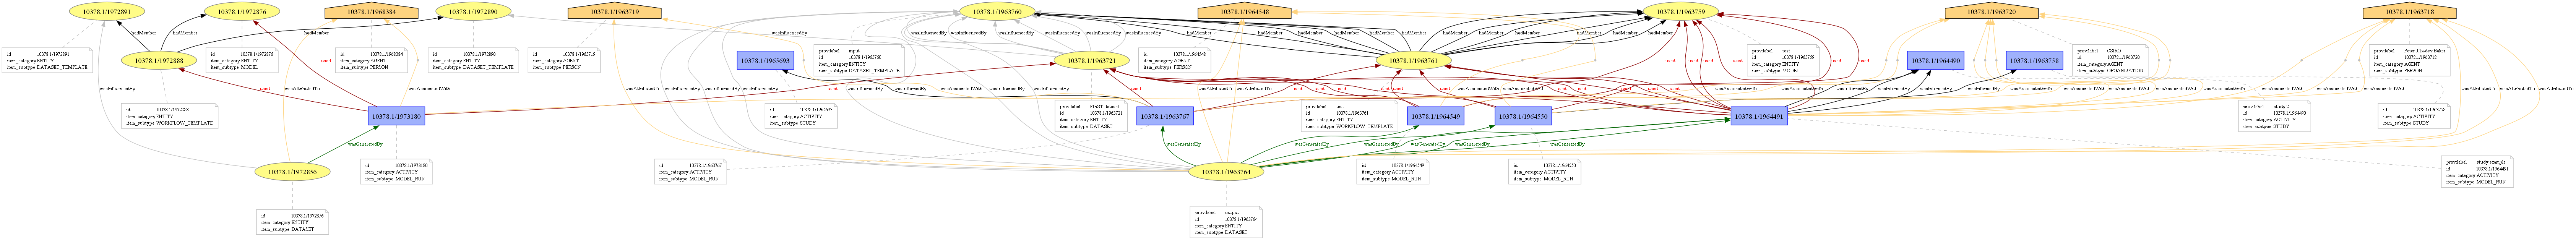

In [ ]:
# render into file
dot = prov_to_dot(document)
name = "prov_graph3"

dot.write_png(name + '.png')
Image(name + '.png')